In [1]:
# get our libraries!
import scipy.stats as st
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pystan as pystan
import pandas as pd
%matplotlib inline

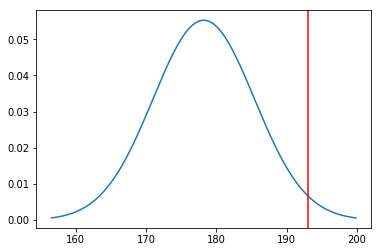

In [258]:
""" 
I'll try to estimate the chances of ODPixel being a certain height! 
I'm sure i've done many things wrong in this analysis, but I found it
a good learning experience. If you have any comments you can leave an issue on github.
First we create a normal distribution for heights
 The following data is from
 https://www.cdc.gov/nchs/data/series/sr_03/sr03_039.pdf
 
The number used represents non-hispanic white american males that are 20-39

#The red line represents the supposed height
 """

h_mean = 178.2
# reconstruct the standard deviation by multiply the standard error by the sqrt
# of sample size
h_std = 0.27*np.sqrt(715)
norm_dist = st.norm(loc=h_mean,scale=h_std)
#construct graph of our population estimate
x = np.linspace(h_mean-h_std*3,h_mean+h_std*3,1000)
y = norm_dist.pdf(x)
plt.plot(x,y)
plt.axvline(193,c='r') #Draw a line at his supposed height!





In [245]:
# Then we ask how much data is captured in 3 standard deviations
bot,top = norm_dist.cdf([h_mean-h_std*3,h_mean+h_std*3])
prob = top-bot
print(prob)
# This covers enough of a range to ignore everything else imo


0.997300203937


In [246]:
# Since we are interested in a question of "what are the chances he is this tall/his most likely height" rather
# than "what is the distribution of our estimate of his height" I will bin the data into
# various categories since we are not very interested in the continous nature of
# the data
x = x #this is height in cm
# convert to inches
_x = x/2.54
#split into feet'inches'' format
f = _x//12 #int divisision so x.y gets cast to x
i = _x%12 #inches out of 12 inches
df = pd.DataFrame({'cm':x,'feet':f,'inches':i}) #store in dataframe
#let's bin the data so that inches of 1.1,1.2,1.3 are converted
# to 1
df['inches_cut']=pd.cut(df['inches'],[0,1,2,3,4,5,6,7,8,9,10,11,12])
#make a new columns representing classic notation of f'i''
_f = df['feet'].map(lambda x: str(x)[0])
_i = df['inches_cut'].map(lambda x: str(x.left)[0] if int(x.left)<10 else str(x.left)[:2]).astype(str)
df['inches_n'] = _f + '\'' + _i + '\'\''
df.sample(5)

,cm,feet,inches,inches_cut,inches_n
147,162.915133,5.0,4.139816,"(4, 5]",5'4''
202,165.300006,5.0,5.078742,"(5, 6]",5'5''
124,161.917822,5.0,3.747174,"(3, 4]",5'3''
297,169.419332,5.0,6.700524,"(6, 7]",5'6''
267,168.118492,5.0,6.188383,"(6, 7]",5'6''


In [247]:
# Now we want to convert these to probability ranges
# Which means a new dataframe which only has one value for each height and
# which sets feet/inches/cm to the base values
df2 = df.drop_duplicates(['inches_n'],inplace=False).copy()
df2.reset_index(drop=True,inplace=True)
df2['feet'] = df2['feet'].astype(int,copy=True)
df2['inches'] = df2['inches'].astype(int,copy=False)
df2['cm'] = df2['feet']*12*2.54 + df2['inches']*2.54
df2

,cm,feet,inches,inches_cut,inches_n
0,154.94,5,1,"(1, 2]",5'1''
1,157.48,5,2,"(2, 3]",5'2''
2,160.02,5,3,"(3, 4]",5'3''
3,162.56,5,4,"(4, 5]",5'4''
4,165.10,5,5,"(5, 6]",5'5''
5,167.64,5,6,"(6, 7]",5'6''
6,170.18,5,7,"(7, 8]",5'7''
7,172.72,5,8,"(8, 9]",5'8''
8,175.26,5,9,"(9, 10]",5'9''
9,177.80,5,10,"(10, 11]",5'10''


0     0.001418
1     0.003852
2     0.009259
3     0.019688
4     0.037035
5     0.061634
6     0.090742
7     0.118193
8     0.136199
9     0.138852
10    0.125236
11    0.099931
12    0.070545
13    0.044058
14    0.024343
15    0.011899
16    0.005145
17    0.001968
Name: prob, dtype: float64


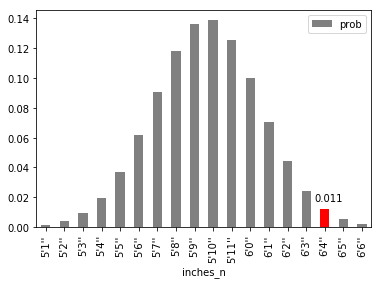

In [248]:
"""
To calculate probabilities I take the cm height and add 
2.54cm to it to get a range. I then put this range into our normal from the beginning"""

def calc_prob(x):
    _a = norm_dist.cdf(x)
    _b = norm_dist.cdf(x+2.54)
    # use difference between cdf evaluations
    # cdf is cumulative density function
    return _b-_a
df2['prob'] = df2['cm'].map(calc_prob)
df2['prob'] = df2['prob']/df2['prob'].sum() # make sure sum = 1
ax = df2.plot(kind='bar',x='inches_n',y='prob')
for bar in ax.patches:
    bar.set_facecolor('grey')
ref = ax.patches[15]
ref.set_facecolor('red')
ax.annotate(str(ref.get_height())[:5],(ref.get_x()*0.98,ref.get_height()*1.5))
ax.legend()
print(df2['prob'])

In [249]:
"""From the above graph we can see that the probability of him being
6'4'' based on the population data is only 1.1%!!!!
An important thing to note is that we have cut off some probabilities, which leads 
to overconfidence in our estimates."""

"From the above graph we can see that the probability of him being\n6'4'' based on the population data is only 1.1%!!!!\nAn important thing to note is that we have cut off some probabilities, which leads \nto overconfidence in our estimates."

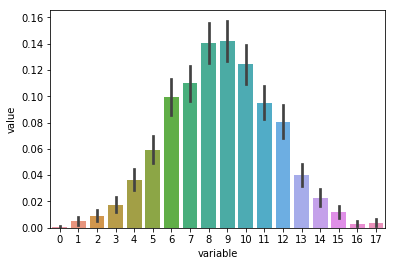

In [251]:
# We will use the dirichlet to estimate our parameters for
# the above categorical distribution
# The reason we do this is that dirichlet is the conjugate prior
# of the categorical distribution
# I showcase below what 1000 samples from a dirichlet using
# our above probilities looks like
a=st.dirichlet(df2['prob']).rvs(1000)
_df = pd.DataFrame(a)
_df = pd.melt(_df,value_vars=range(0,18))
sns.barplot(data=_df,x='variable',y='value')

In [252]:
"""
Let us use Stan, a statistical modelling language, to estimate a new categorical distribution
from our one sample of 6'4"
A brief theoretical background for this work is that we are essentially using Bayes rule
to compute P(theta|x)=P(x|theta)p(theta)/P(x)
Here p(theta) is our prior, which is our dirichlet distibution from the population data
p(x|theta) is our likelihood, an estimate of our sample given our prior. Categorical dist
p(x) is our marginal likelihood
p(theta|x) is our posterior, our estimate of theta after seeing the data. Also a categorical dist

What we want to do is maximize our likelihood of observing our sample x, by playing around
with the value of theta. In this case, we do it with stan by searching our solution space
using markov chain monte carl (MCMC)

"""
height_code = """
data {
    int<lower=0> K;
    int<lower=0, upper=K> obs;
    simplex[K] alpha;
}
parameters {
    simplex[K] s;
}
model {
    s ~ dirichlet(alpha);
    obs ~ categorical(s);
}
"""
sm = pystan.StanModel(model_code=height_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6301dded9584a16d76f94772ac584695 NOW.


In [253]:
height_dat ={'K':18,'obs':16,'alpha':df2['prob']}
fit = sm.sampling(data=height_dat,chains=10)
fit

Inference for Stan model: anon_model_6301dded9584a16d76f94772ac584695.
10 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=10000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
s[0]  8.9e-4  2.4e-4   0.023.1e-2961.4e-1998.5e-1185.0e-57 5.6e-6   4196    1.0
s[1]  1.6e-3  3.1e-4   0.021.7e-2727.5e-1481.8e-746.4e-32 8.5e-4   3793    1.0
s[2]  4.4e-3  3.9e-4   0.045.4e-1561.1e-614.9e-322.3e-14   0.03   8646    1.0
s[3]    0.01  7.2e-4   0.069.2e-887.5e-361.6e-18 8.3e-8   0.13   6608    1.0
s[4]    0.02  1.1e-3   0.072.7e-424.4e-18 1.5e-9 1.5e-4   0.24   4268    1.0
s[5]    0.03  1.8e-3    0.11.0e-291.8e-11 3.8e-6 3.6e-3   0.36   3162    1.0
s[6]    0.05  2.7e-3   0.125.9e-22 1.4e-7 1.8e-4   0.02   0.48   2175    1.0
s[7]    0.06  2.8e-3   0.138.3e-14 2.0e-6 1.3e-3   0.04   0.49   2223    1.0
s[8]    0.07  3.3e-3   0.146.8e-13 1.9e-5 3.1e-3   0.05   0.54   1837   1.01
s[9]    0.08  3.6e-3   0.161.0e-1

In [256]:
#Let us grab the results from our simulation 
#and visualize them!
data = fit.get_posterior_mean()[:-1]
means = list(map(lambda x:np.average(x), data))
std = list(map(lambda x:np.std(x), data))
df2['new_prob'] = means
df2['std'] = std

0     0.001418
1     0.003852
2     0.009259
3     0.019688
4     0.037035
5     0.061634
6     0.090742
7     0.118193
8     0.136199
9     0.138852
10    0.125236
11    0.099931
12    0.070545
13    0.044058
14    0.024343
15    0.011899
16    0.005145
17    0.001968
Name: prob, dtype: float64


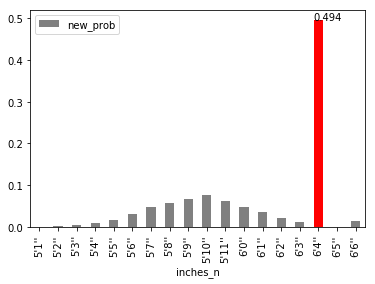

In [257]:
ax = df2.plot(kind='bar',x='inches_n',y='new_prob')
for bar in ax.patches:
    bar.set_facecolor('grey')
ref = ax.patches[15]
ref.set_facecolor('red')
ax.annotate(str(ref.get_height())[:5],(ref.get_x()*1,ref.get_height()*1))
ax.legend()
print(df2['prob'])

Seeing such a rare recording greatly shifts the probability of it being true towards ~50%
One important thing to note about this is that we do not plot the standard deviations from
our estimate. This is a pretty big source of error, but I'm not going to go through that effort
right now :)